In [ ]:
%pip install pytorch-pretrained-bert

In [ ]:
%pip install --upgrade tensorflow

In [ ]:
%pip install 'keras<3.0.0' mediapipe-model-maker

In [ ]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.transforms as transforms
import os
import sys
input_dir = r'D:\clg files\RecSys\py_files'
sys.path.append(input_dir)

from data_util import AttDesDataset
from utils import weights_init

# from dcgan_model import Generator, Discriminator
import time
import imageio
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)

In [ ]:
# directory to store output images
output_save_path = './generated_images/'
os.makedirs(output_save_path, exist_ok=True)

In [ ]:
# directory to store trained models
model_save_path = './saved_models/'
os.makedirs(model_save_path, exist_ok=True)

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from torch.nn.utils.rnn import pad_sequence

class CustomDataset(Dataset):
    def __init__(self, data):
        self.images = data['images']
        self.captions = data['captions']

    def __getitem__(self, index):
        image = self.images[index]
        caption = self.captions[index]
        caption_tensor = torch.tensor(caption)
        return image, caption_tensor

    def __len__(self):
        return len(self.images)

In [ ]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]

    # Stack images
    images = torch.stack(images, 0)

    # Truncate or pad captions
    max_length = 128  # whatever fixed length
    captions = [cap[:max_length] for cap in captions]  # Truncate
    embedding_size = 768 
    captions = [torch.cat([cap, torch.zeros(max_length - cap.size(0), embedding_size)]) for cap in captions]

    # Stack captions
    captions = torch.stack(captions, 0)

    return images, captions

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

data_root = r'data_files\smoll.csv'
split_root = ''
dataset_name = 'Furniture'
normalize = transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
batch_size = 2 #128
dataset = AttDesDataset(data_root, dataset_name, transform=transforms.Compose([
                                            transforms.Resize((448,448)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            normalize,
                                        ]))

temp_dataset = {'images': dataset.images, 'captions': dataset.descriptions}
custom_dataset = CustomDataset(temp_dataset)
print(len(custom_dataset))
# print(len(custom_dataset['captions']))
num_samples = len(custom_dataset)
indices = list(range(num_samples))
split = int(np.floor(0.8 * num_samples))  # 80-20 train-validation split

# Randomly shuffle the indices
np.random.shuffle(indices)

# Split the indices into train and validation sets
train_indices, val_indices = indices[:split], indices[split:]

# Define samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Define DataLoader for train and validation sets using samplers
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=0)

# Check the number of batches in train and validation loaders
print("No of batches in train loader: ", len(train_loader))
print("No of batches in validation loader: ", len(val_loader))



In [38]:
len(dataset.images)

440

In [39]:
len(dataset.descriptions)

440

In [40]:
dataset.images[0].shape

torch.Size([3, 448, 448])

In [41]:
len(dataset.descriptions[0])

100

In [42]:
print(dataset.descriptions[0])

tensor([[-0.0150,  0.0679, -0.3162,  ...,  0.1928, -0.0249, -0.0837],
        [ 0.7369,  1.4449,  0.5900,  ..., -1.6133, -1.0846, -0.1246],
        [ 0.7197, -0.5051,  0.0557,  ..., -1.1547,  1.2858,  0.1948],
        ...,
        [-0.4454,  0.9170, -0.8079,  ...,  0.8319, -0.8192,  0.2363],
        [-0.1958,  0.8614, -1.5305,  ...,  1.7604, -0.1398,  0.1652],
        [-0.6419,  0.0651, -0.7662,  ...,  1.7326, -0.7238,  0.4408]])


In [43]:
print(len(temp_dataset['captions'][0]))

100


In [44]:
len(custom_dataset[1][1])

100

In [45]:
# for i, data in enumerate(train_loader):
#     print(type(data))  # This will print the type of the data element
#     if isinstance(data, list) or isinstance(data, tuple):
#         print(len(data))  
#     elif isinstance(data, dict):
#         print(data.keys())
#     if i >= 0: 
#         break

In [46]:
prev1 = 448

for batch_idx,batch in enumerate(train_loader):
    print(batch_idx)
    # print(batch)
    # print(type(batch))
    # print(batch[0].shape)
    # print(batch[1].shape)
    # print(batch[1].shape)

    if(batch[0].shape[2] != prev1 and batch[3].shape[0] != prev1):
        print("Batch size mismatch")
        print(f'batch_idx: {batch_idx}, batch[0].shape: {batch[0].shape}, batch[1].shape: {batch[1].shape}')
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


In [47]:
print(len(custom_dataset.captions[0]))

100


In [48]:
# setting up parameters
noise_dim = 100
embed_dim = 768
embed_out_dim = 100
batch_size = 2 #128
real_label = 1
fake_label = 0
learning_rate = 0.0002
l1_coef = 50
l2_coef = 100

num_epochs = 1
log_interval = 18 #43

In [49]:
# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [50]:
# lists to store losses
D_losses = []
G_losses = []

In [51]:
# initializing generator
from dcgan1 import Generator, Discriminator

generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(10100, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1

In [52]:
# initializing discriminator
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=768, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, mom

In [53]:
# setting up Adam optimizer for Generator and Discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [54]:
# training loop
import torch.nn.functional as F
import PIL
# iterating over number of epochs
from datetime import date

start_time = time.time()
for epoch in range(num_epochs):
    
    batch_time = time.time()
    print('Epoch: {}'.format(epoch+1))
    #iterating over each batch
    for batch_idx,batch in enumerate(train_loader):   

        print(f'epoch: {epoch+1}, batch: {batch_idx+1}/{len(train_loader)}')
        print(batch_idx)
        
        # reading the data into variables and moving them to device
        images = batch[0].to(device)
        # print('hi after images')
        wrong_images = batch[0].to(device)
        # print('hi after wrong images')
        embeddings = batch[1].to(device).float()

        batch_size = images.size(0)
        # print(f'embeddings size: {embeddings.size()}')
        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        # print('training the descriminator')
        # Clear gradients for the discriminator
        optimizer_D.zero_grad()
        
        # Generate random noise
        noise_dim = 100  
        batch_size = images.size(0)
        noise = torch.randn(embeddings.size(0), noise_dim).to(device)
        # noise = noise.view(embeddings.size(0), noise_dim, 1, 1)
   
        # Generate fake image batch with the generator
        # print(f'noise size: {noise.size()}')
        # print(f'embeddings size: {embeddings.size()}')
        fake_images = generator(noise, embeddings)
        # print('hi after fake images')
        # print(f'fake_images size: {fake_images.size()}')
        fake_images = F.interpolate(fake_images, size=(448, 448), mode='bilinear', align_corners=False)
        # print('fake images after interpolation: ', fake_images.size())
        # Forward pass real batch and calculate loss

        real_out, real_act = discriminator(images, embeddings)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))
        
        # Forward pass wrong batch and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embeddings)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))
        
        # Forward pass fake batch and calculate loss
        # fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
        # d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))
        
        # Compute total discriminator loss
        d_loss = d_loss_real + d_loss_wrong #+ d_loss_fake
        
        # Backpropagate the gradients
        d_loss.backward()
        
        # Update the discriminator
        optimizer_D.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        # print('Training the generator')
        # Clear gradients for the generator
        optimizer_G.zero_grad()
       
        # Generate new fake images using Generator
        fake_images = generator(noise, embeddings)
        # print(f'fake_images size: {fake_images.size()}')
        fake_images = F.interpolate(fake_images, size=(448, 448), mode='bilinear', align_corners=False)
        # print('fake images after interpolation: ', fake_images.size())
        # Get discriminator output for the new fake images
        out_fake, act_fake = discriminator(fake_images, embeddings)
        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embeddings)
        
        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device)) 
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())
        
        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2
        
        # Backpropagate the gradients
        g_loss.backward()
        
        # Update the generator
        optimizer_G.step()
        
        # adding loss to the list
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        
        # progress based on log_interval
        if (batch_idx+1) % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
                          epoch+1, batch_idx+1, len(train_loader),
                          d_loss.mean().item(),
                          g_loss.mean().item(),
                          time.time() - batch_time))
        
        # storing generator output after every 10 epochs
        if batch_idx == len(train_loader)-1 and ((epoch+1)%10==0 or epoch==0):
            viz_sample = torch.cat((images[:32], fake_images[:32]), 0)
            vutils.save_image(viz_sample,
            os.path.join(output_save_path, 'output_{}_epoch_{}.png'.format(date.today(),epoch+1)),
                              nrow=8,normalize=True)
            viz_sample.show()


# saving the trained models
torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_{}.pth'.format(date)))
torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator_{}.pth'.format(date)))
        
print('Total train time: {:.2f}'.format(time.time() - start_time))

Epoch: 1
epoch: 1, batch: 1/220
0
epoch: 1, batch: 2/220
1
epoch: 1, batch: 3/220
2
epoch: 1, batch: 4/220
3
epoch: 1, batch: 5/220
4
epoch: 1, batch: 6/220
5
epoch: 1, batch: 7/220
6
epoch: 1, batch: 8/220
7
epoch: 1, batch: 9/220
8
epoch: 1, batch: 10/220
9
epoch: 1, batch: 11/220
10
epoch: 1, batch: 12/220
11
epoch: 1, batch: 13/220
12
epoch: 1, batch: 14/220
13
epoch: 1, batch: 15/220
14
epoch: 1, batch: 16/220
15
epoch: 1, batch: 17/220
16
epoch: 1, batch: 18/220
17
Epoch 1 [18/220] loss_D: 2.1319 loss_G: 46.1750 time: 36.20
epoch: 1, batch: 19/220
18
epoch: 1, batch: 20/220
19
epoch: 1, batch: 21/220
20
epoch: 1, batch: 22/220
21
epoch: 1, batch: 23/220
22
epoch: 1, batch: 24/220
23
epoch: 1, batch: 25/220
24
epoch: 1, batch: 26/220
25
epoch: 1, batch: 27/220
26
epoch: 1, batch: 28/220
27
epoch: 1, batch: 29/220
28
epoch: 1, batch: 30/220
29
epoch: 1, batch: 31/220
30
epoch: 1, batch: 32/220
31
epoch: 1, batch: 33/220
32
epoch: 1, batch: 34/220
33
epoch: 1, batch: 35/220
34
epoch

OSError: [Errno 22] Invalid argument: "D:\\clg files\\RecSys\\generated_images\\output_<class 'datetime.date'>_epoch_1.png"

In [69]:
viz_sample.size()

torch.Size([4, 3, 448, 448])

In [70]:
import torchvision.utils as vutils
import os
from datetime import date

# Assuming output_save_path and epoch are defined
output_save_path = './'
epoch = 1

vutils.save_image(viz_sample, os.path.join(output_save_path, 'output_{}_epoch_{}.png'.format(date.today(), epoch+1)), normalize=True)

In [68]:
viz_sample = torch.cat((images[:32], fake_images[:32]), 0)
vutils.save_image(viz_sample,
                  os.path.join(output_save_path, 'output_{}_epoch_{}.png'.format(date.today(),epoch+1)),
                              nrow=8,normalize=True)
viz_sample.show()

RuntimeError: stack expects a non-empty TensorList

In [56]:
from PIL import Image
import torchvision.transforms as transforms

# Assuming viz_sample is your tensor
# First, detach and move the tensor to cpu
viz_sample = viz_sample.detach().cpu()

# Convert the tensor to a PIL Image
viz_sample_pil = transforms.ToPILImage()(viz_sample)

# Display the image
viz_sample_pil.show()

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

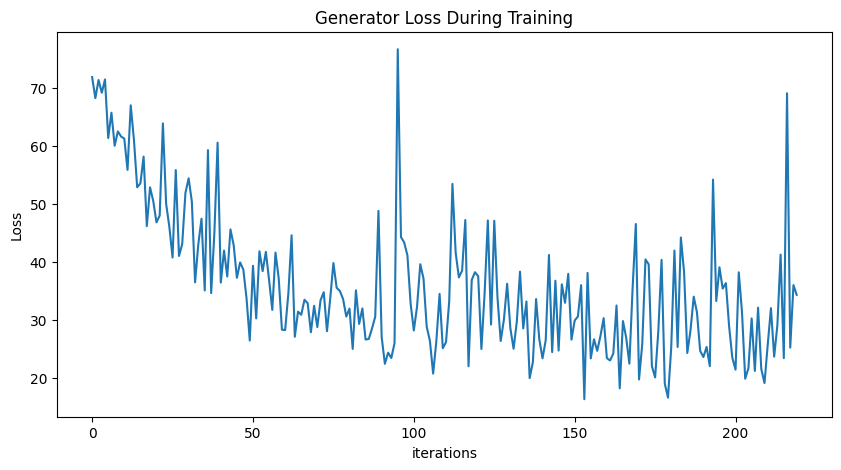

<Figure size 640x480 with 0 Axes>

In [66]:
# generator loss plot
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_generatorLoss_{}.png'.format(date.today())))

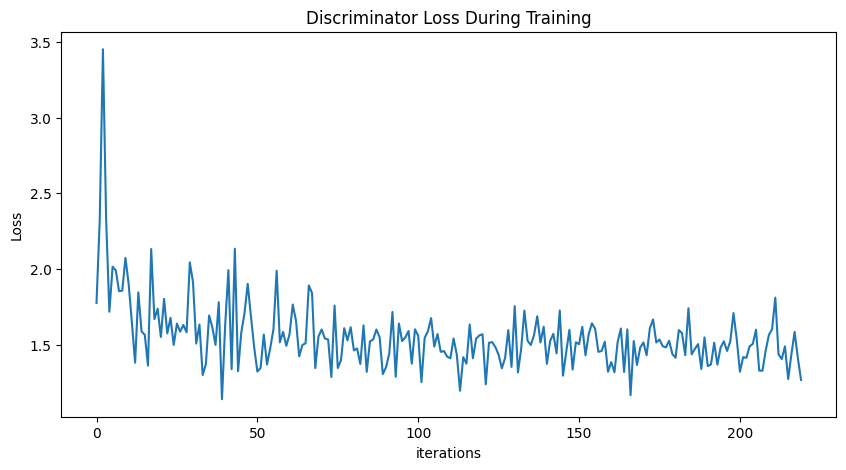

<Figure size 640x480 with 0 Axes>

In [63]:
# discriminator loss plot
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_discriminatorLoss_{}.png'.format(date.today())))

In [ ]:
from IPython.display import Image

# Load the GIF
with open(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)),'rb') as file:
    display(Image(file.read()))